<h1><center><font color='blue'>ML 2, 2020, By Prof. Dr Jan Nagler </font></center></h1>

<h2><center><font color='red'>Topic: Hyperparameter tuning with Bayesian Optimization a.k.a Sequential Model-Based Optimization (SMBO) </font></center></h2>

## Solutions to Assignment 5 (MINI_PROJECT). 
#### Submitted By: Shaikh Muhammad Asjad Raza


<h2><font color='blue'>Import the necessary libraries </font></h2>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.scorer import SCORERS
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
#import lightgbm as lgb
import random
import time
%matplotlib inline

from scipy import stats

import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#plt.rcParams['figure.figsize'] = (10,10)

<h2><font color='Green'>Idea Behind Bayisan Optimization, Specifically Tree Parzen Estimator</font></h2>

Surrogate Function(TPE):   P(Accuracy|Hyperparameters)

Bayes Rule in Action:

P(Accuracy|Hyperparameters) = (P(Hyperparameter|Accuracy) P(Accuracy)) / P(Hyperparameter)

According to TPE, P(Hyperparameter|Accuracy) is divided into two distributions l(x) and g(x). (Unlike Gaussian Process)

Note: TPE takes -ve accuracy score and minimizes it. Minizing the -ve accuracy score is equal to maximizing the +ve accuracy score.

l(x) = Distribution of Hyperparameters that produces accuracy below a certain threshold. (Good Hyperparameter values)

g(x) = Distribution of Hyperparameters that produces accuracy greater than or equal to a certain threshold. (Bad Hyperparameter values)




In [2]:
colors = plt.rcParams['axes.prop_cycle']
colors = [c['color'] for c in colors]

(-1, 16)

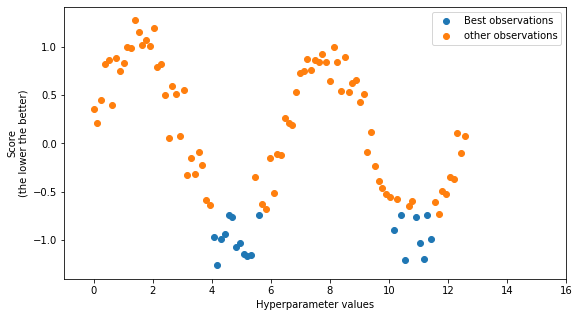

In [3]:
def f(x):
    return np.sin(x) + 0.2 * np.random.randn(*x.shape)

np.random.seed(0)

x = np.linspace(0, 4 * np.pi, 100)
y = f(x)

best_ratio = 0.2
n_best = int(len(x) * best_ratio)

y_sorted_index = np.argsort(y)
y_sorted = y[y_sorted_index]
x_sorted = x[y_sorted_index]

x_best = x_sorted[:n_best]
y_best = y_sorted[:n_best]

x_worst = x_sorted[n_best:]
y_worst = y_sorted[n_best:]

plt.figure(figsize=(9, 5))
plt.scatter(x_best, y_best, color=colors[0],
            label="Best observations")
plt.scatter(x_worst, y_worst, color=colors[1],
            label="other observations")
plt.legend(loc='upper right')

plt.ylabel("Score\n(the lower the better)")
plt.xlabel("Hyperparameter values")
plt.xlim(-1, 16)


<h3><font color='blue'>Imagine we are dealing with a single Hyperparameter. Points in blue shows the optimal hyperparameter values.</font></h3>

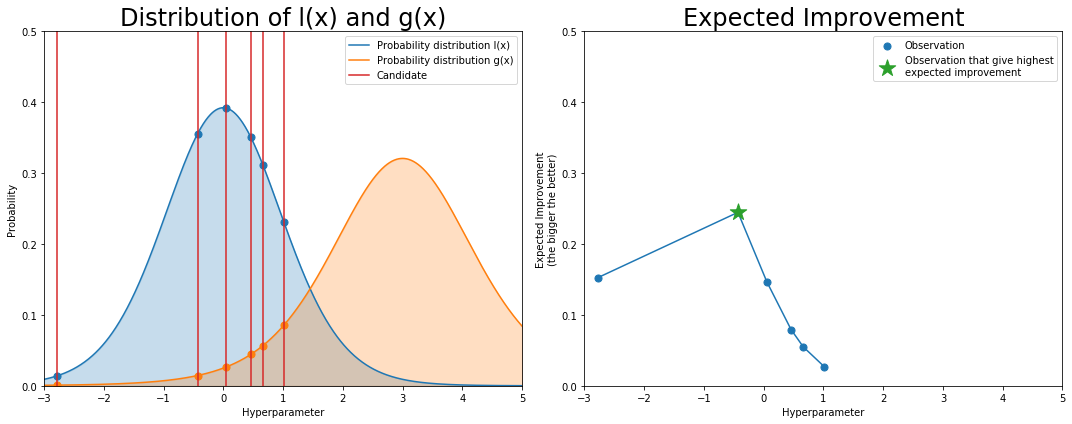

In [4]:
np.random.seed(2)

best_proba = stats.t(15, 0, 1)
worst_proba = stats.t(7, 3, 1.2)

x = np.linspace(-3, 5, 1000)
y_best = best_proba.pdf(x)
y_worst = worst_proba.pdf(x)

fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(1, 2, 1)

best_proba_line, = ax.plot(x, y_best, color=colors[0])
ax.fill_between(x, 0, y_best, color=colors[0], alpha=0.25)

worst_proba_line, = ax.plot(x, y_worst, color=colors[1], label='g(x)')
ax.fill_between(x, 0, y_worst, color=colors[1], alpha=0.25)

x_candidates = best_proba.rvs(6)
for x_candidate in x_candidates:
    candidate_line = ax.axvline(x_candidate, 0, 1,
                                 color=colors[3])
    ax.scatter(x_candidate, best_proba.pdf(x_candidate),
                s=50, color=colors[0])
    ax.scatter(x_candidate, worst_proba.pdf(x_candidate),
                s=50, color=colors[1])


ax.set_title('Distribution of l(x) and g(x)', size = 24)
plt.ylabel("Probability")
plt.xlabel("Hyperparameter")
plt.xlim(-3, 5)
plt.ylim(0, 0.5)

plt.legend([
        best_proba_line,
        worst_proba_line,
        candidate_line,
    ], [
        'Probability distribution l(x)',
        'Probability distribution g(x)',
        'Candidate',
    ],
    loc='upper right'
)

ax = fig.add_subplot(1, 2, 2)
x_candidates.sort()
expected_improvement = (best_proba.pdf(x_candidates) / worst_proba.pdf(x_candidates))/100
max_index = expected_improvement.argmax()
ax.plot(x_candidates, expected_improvement)
ax.scatter(x_candidates, expected_improvement, color=colors[0], s=50,
            label='Observation')

ax.scatter(x_candidates[max_index], expected_improvement[max_index],
            marker='*', s=300, color=colors[2], zorder=10,
            label='Observation that give highest\nexpected improvement')


ax.set_title('Expected Improvement', size = 24)
plt.ylabel("Expected Improvement\n(the bigger the better)")
plt.xlabel("Hyperparameter")
plt.xlim(-3, 5)
plt.ylim(0, 0.5)
plt.legend(loc='upper right')

fig.tight_layout()
plt.show()

l(x) Good Group
g(x) Bad Group 
<h2><font color='blue'>We want to draw samples which are more likely under l(x) rather than g(x). Maximize the ratio l(x)/g(x). Expected Improvement is directly propotional to l(x)/g(x). The higer this ratio, the greater the Expected improvement will be.</font></h2>
<h2><font color='blue'>l(x) and g(x) makes a mixture of Gaussians. Each mixutre is updated on every iteration after which it is used to sample the next hyperparamter that maximizes the Expected Improvement.</font></h2>

<h1><center><font color='Green'>-------------------------------------Implementation------------------------------------------</font></h1>




<h4><font color='blue'>Breast Cancer Dataset</font></h4>

In [5]:
#Load dataset
cancer = datasets.load_breast_cancer()

# Convert to df
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

In [6]:
#df.head(5)

In [7]:
# Normalize the data
sc = StandardScaler()
df = sc.fit_transform(df)
df = pd.DataFrame(df, columns =cancer.feature_names)

### Define F2-Scorer

In [8]:
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta=2, pos_label=0, average='binary')
  
#f2 = make_scorer(f2_scorer, greater_is_better=True)
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer

make_scorer(fbeta_score, beta=2)

<h2><font color='blue'>Splitting into train and test set</font></h2>


In [9]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.3, random_state=330)

<h2><font color='blue'>Domain Space for Hyperopt Baysian Optimisation</font></h2>

In [10]:
param_hyper_opt = {'C': hp.loguniform('C', np.log(0.9), np.log(3.0)),
                   'gamma':hp.loguniform('gamma', np.log(0.01), np.log(1.0)) } #evenly distributing float values on a logarithmic scale


#param_hyper_opt = {'C': hp.uniform('C', 0, 10), 'gamma': hp.uniform('gamma', 0, 10) }


<h2><font color='blue'>Lets see how the search domain is distributed. Sampling 500 values from C and Gamma Distribution.</font></h2>

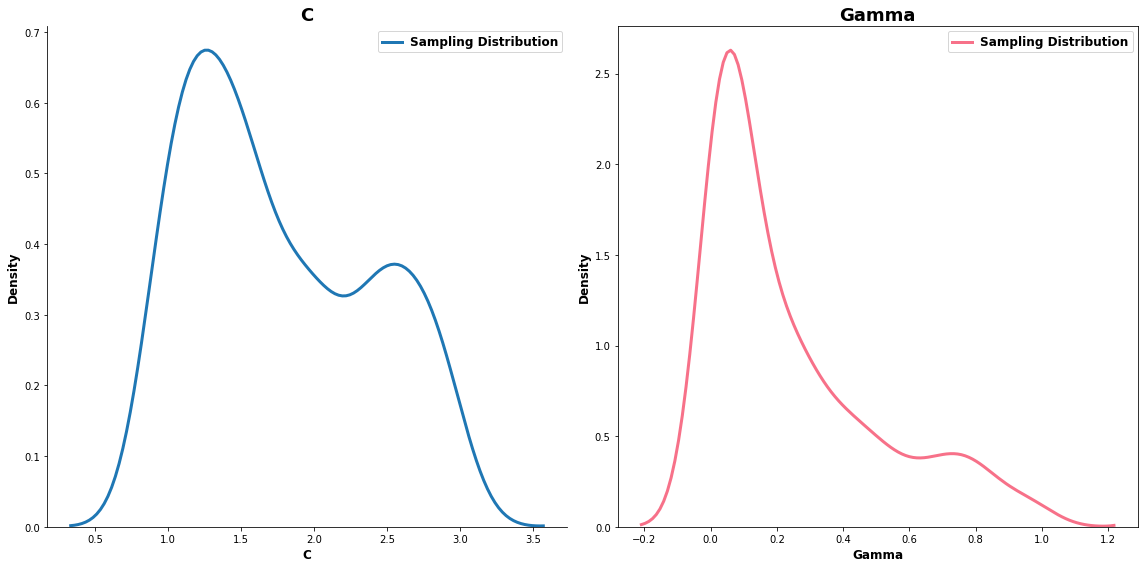

In [11]:
C_dist = [sample(param_hyper_opt ['C'])for x in range(500)]
Gamma_dist = [sample(param_hyper_opt ['gamma'])for x in range(500)]
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
sns.set_palette("husl")
sns.despine()
ax = sns.kdeplot(C_dist, label = 'Sampling Distribution', linewidth = 3)
plt.title("C", fontsize=18, fontweight='bold')
plt.xlabel('C', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold');
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')
   
ax = fig.add_subplot(1, 2, 2)
ax = sns.kdeplot(Gamma_dist, label = 'Sampling Distribution', linewidth = 3)
plt.title("Gamma", fontsize=18, fontweight='bold')
plt.xlabel('Gamma', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold');
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')
fig.tight_layout()
plt.show()

<h2><font color='blue'>hp.loguniform helps in sampling values that we want or ideally want to attack on</font></h2>

In [12]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'f2_score': make_scorer(f2_scorer, greater_is_better=True)
}

# Hyperopt Function

# SVM with RFB Kernal

<h2><font color='blue'>Define Objective Function for SVM with RBF Kernal</font></h2>
<h4><font color='blue'>Returns the -ve accuracy score. We want to minimize the -ve accuracy score to reach optimium. Status returns the parametrs evaluated.</font></h4>

In [13]:
def objective_function(params):
  svm_clf = svm.SVC(class_weight='balanced')
  svm_clf = svm_clf.set_params(**params)
  score = cross_val_score(svm_clf, X_train, y_train, cv=5).mean()
  return {'loss': -score, 'status': STATUS_OK}

<h2><font color='blue'>Define the Surrogate Function (Tree Parzen Estimator)</font></h2>
<h4><font color='blue'>We dont want to run the Objective function on every possible combination of C and Gamma (Hyperparameters).</font></h4>
<h5><font color='blue'>Trial object stores basic training information and the dictionary returned from the objective function (being the scores and their corresponding parameters).</font></h5>



In [14]:
def hyperopt_function(param_hyper_opt, num_evals):
  trials = Trials()
  best_param = fmin(objective_function,
                    param_hyper_opt, 
                    algo=tpe.suggest, 
                    max_evals=num_evals, 
                    trials=trials,
                    rstate= np.random.RandomState(1))
  return trials, best_param

<h3><font color='blue'>TPE uses Expected Improvement as an Acquision Fuction/Selection Function that tells the next best area to sample from.</font></h3>

In [15]:
num_eval = 500
results_hyperopt, best = hyperopt_function(param_hyper_opt, num_eval)

100%|██████████| 500/500 [00:18<00:00, 27.32trial/s, best loss: -0.9798409907798094]


In [16]:
# Retrieve Hyperopt scores
hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
hyperopt_scores = np.maximum.accumulate(hyperopt_scores)
tpe_results = pd.DataFrame({'loss': [trial['result']['loss'] for trial in results_hyperopt.trials], 
                            'iteration': [trial['misc']['idxs']['C'][0] for trial in results_hyperopt.trials],
                            'C': [trial['misc']['vals']['C'][0] for trial in results_hyperopt.trials],
                            'Gamma': [trial['misc']['vals']['gamma'][0] for trial in results_hyperopt.trials]})
                            

<h3><font color='blue'>Best Hyperparameters returned by TPE.</font></h3>

In [17]:
# Print best parameters
best_params = space_eval(param_hyper_opt, best)
print("BEST PARAMETERS: " + str(best_params))

BEST PARAMETERS: {'C': 1.173525907280103, 'gamma': 0.012160494128826905}


<h3><font color='blue'>Determine Iterations it took to reach the optimum score.</font></h3>

[None, None]

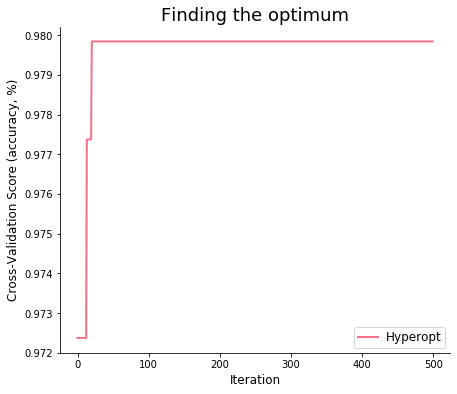

In [18]:
# Plot evaluation scores of each method over time

f, ax = plt.subplots(figsize=(7,6))
sns.set_palette("husl")
sns.despine()
#ax = sns.lineplot(x=[x for x in range(num_eval)], y=random_scores, linewidth = 2)
ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
plt.title("Finding the optimum", fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)
plt.legend(loc='lower right', labels=['Hyperopt'])
plt.setp(ax.get_legend().get_texts(), fontsize='12')

<h2><font color='blue'>Lets see how the sampling distribution (initial hyperparameter domain) is changed by TPE</font></h2>

In [19]:
C_dist = [sample(param_hyper_opt ['C'])for x in range(500)]
Gamma_dist = [sample(param_hyper_opt ['gamma'])for x in range(500)]

In [20]:
# Retrieve learning rates and num_leaves' used by Hyperopt
C_hp = [trial['misc']['vals']['C'][0] for trial in results_hyperopt.trials]
Gamma_hp = [trial['misc']['vals']['gamma'][0] for trial in results_hyperopt.trials]

In [21]:
# Restoring search history and best point
C_Gamma_HP = [[trial['misc']['vals']['C'][0] for trial in results_hyperopt.trials],
              [trial['misc']['vals']['gamma'][0] for trial in results_hyperopt.trials]]

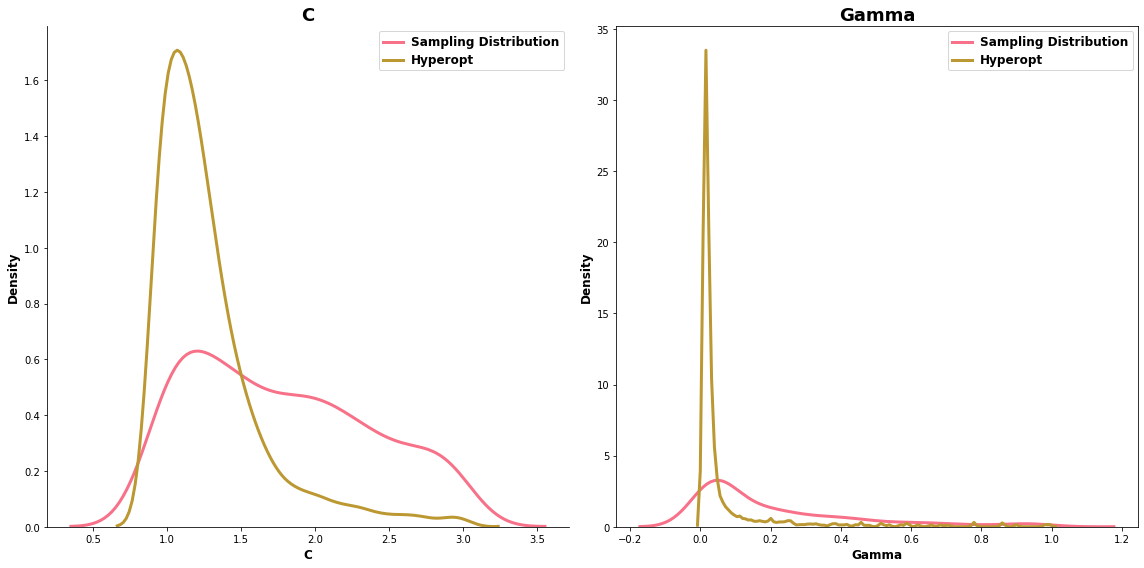

In [22]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
sns.set_palette("husl")
sns.despine()
ax = sns.kdeplot(C_dist, label = 'Sampling Distribution', linewidth = 3)
ax = sns.kdeplot(C_hp, label = 'Hyperopt', linewidth = 3)

plt.title("C", fontsize=18, fontweight='bold')
plt.xlabel('C', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold');
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')
   
ax = fig.add_subplot(1, 2, 2)
ax = sns.kdeplot(Gamma_dist, label = 'Sampling Distribution', linewidth = 3)
ax = sns.kdeplot(Gamma_hp, label = 'Hyperopt', linewidth = 3)
plt.title("Gamma", fontsize=18, fontweight='bold')
plt.xlabel('Gamma', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold');
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')
fig.tight_layout()
plt.show()

In [23]:
#loss = [x['result']['loss'] for x in results_hyperopt.trials]
#best_param_values = [x for x in best_param.values()]
#hyperopt_scores
#best_HO = (-trls.best_trial['result']['loss'], (space_eval(hp_space, res_HO)['x'],  space_eval(hp_space, res_HO)['y']))
best['C']

1.173525907280103

In [24]:
svm_clf = svm.SVC(class_weight='balanced')
svm_clf = svm_clf.set_params(C = best['C'], gamma = best['gamma'])
svm_clf.fit(X_train, y_train)

SVC(C=1.173525907280103, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.012160494128826905,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [25]:
Y_test_pred = svm_clf.predict(X_test)

<h3><font color='blue'>Accuracy Score on Test Data</font></h3>

In [26]:
test_set_score = accuracy_score(y_test, Y_test_pred) #F2_Score
print("Accuracy Score on Test Data: %.3f" % test_set_score)

Accuracy Score on Test Data: 0.977


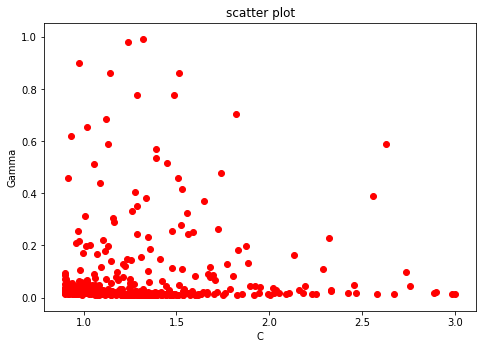

In [27]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(C_Gamma_HP[0],C_Gamma_HP[1],  color='r')

ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_title('scatter plot')
plt.show()

<h3><font color='blue'>We can see how the the best hyperparameters are sampled. Optimal C and Gamma are close to 0, we can also see that Baysian Optimazation did not search for every possible combination (unlike Grid Search) instead it took infromed steps to reach the best hyperparamenters (unlike Random Search). Trade off between Exploration and Exploitation</font></h3>

<h3><font color='blue'>Visualizing the distribution of hyperparameters with respect to loss(-ve accuracy score). The lower the better...</font></h3>

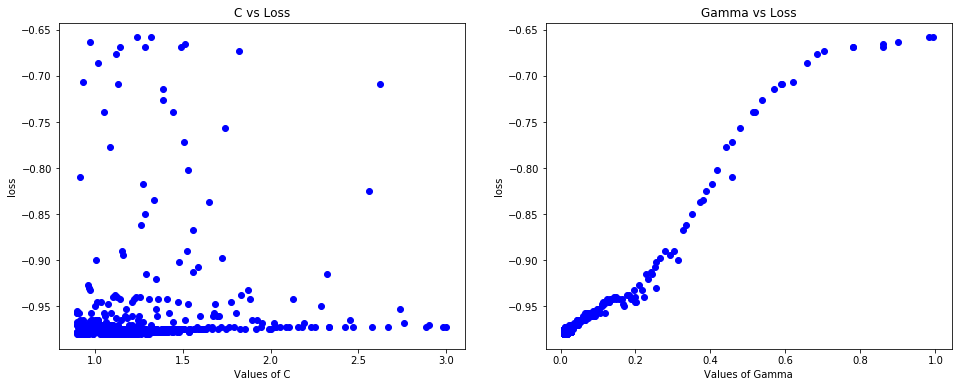

In [28]:
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(tpe_results['C'], tpe_results['loss'], 'bo');
plt.xlabel('Values of C'); plt.ylabel('loss'); plt.title('C vs Loss');

ax = fig.add_subplot(1, 2, 2)
plt.plot(tpe_results['Gamma'], tpe_results['loss'], 'bo');
plt.xlabel('Values of Gamma'); plt.ylabel('loss'); plt.title('Gamma vs Loss');

<h3><font color='blue'></font></h3>

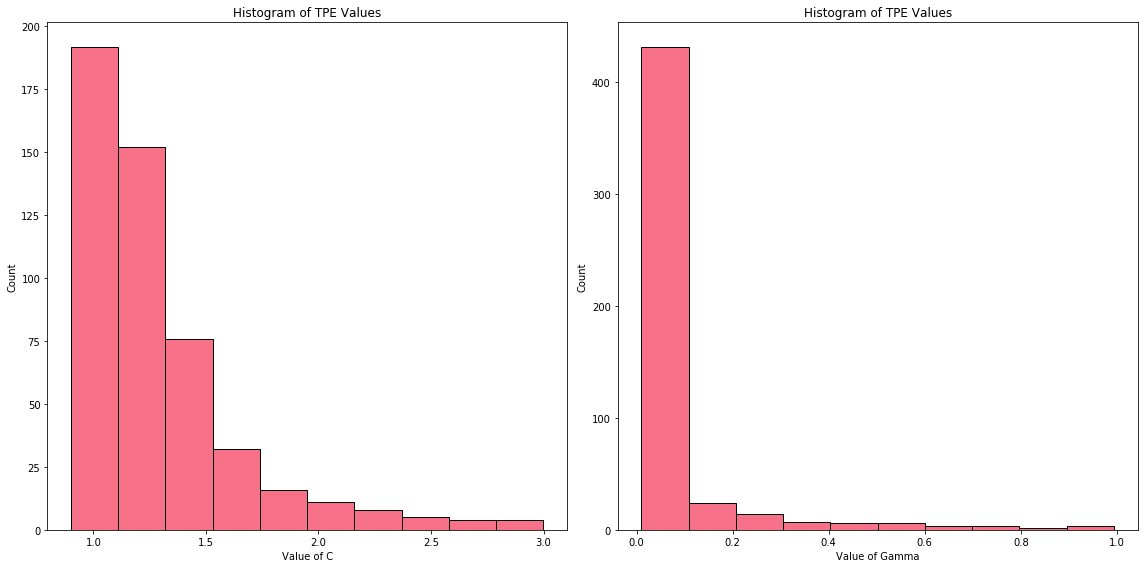

In [29]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.hist(tpe_results['C'], bins = 10, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of C'); plt.ylabel('Count');
   
ax = fig.add_subplot(1, 2, 2)
ax.hist(tpe_results['Gamma'], bins = 10, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of Gamma'); plt.ylabel('Count');
fig.tight_layout()
plt.show()

<h3><font color='blue'>Loss VS the Combined distribution of samples on Interations. Again we can analytically see the trade-of between Exploration and Exploitation handled by the Acusition Function or Selection Function</font></h3>

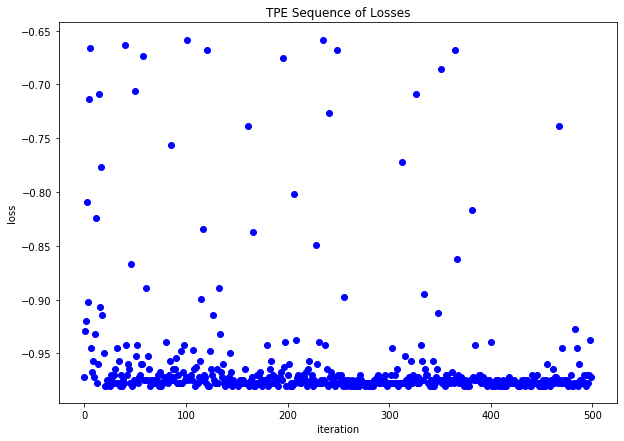

In [30]:
fig = plt.figure(figsize = (10, 7))
plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo');
plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');

#print('Best Loss of {:.4f} occured at iteration {}'.format(tpe_results['loss'][0], tpe_results['iteration'][0]))

<h3><font color='blue'>Indivisual Distribution of Hyperparameters over the iterations.</font></h3>

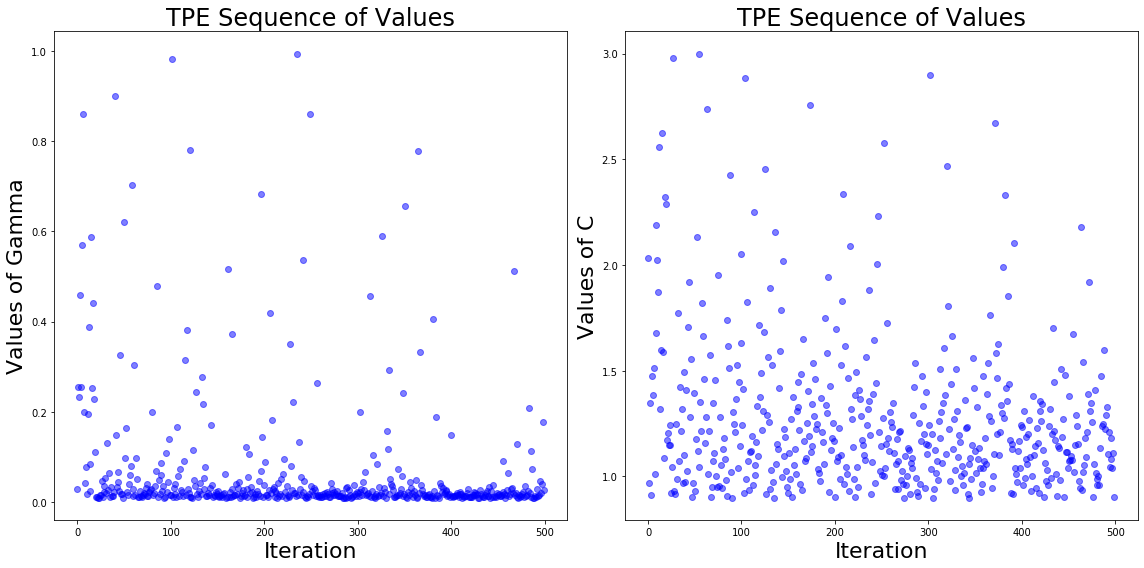

In [31]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.plot(tpe_results['iteration'], tpe_results['Gamma'],  'bo', alpha = 0.5)
ax.set_xlabel('Iteration', size = 22) 
ax.set_ylabel('Values of Gamma', size = 22)
ax.set_title('TPE Sequence of Values', size = 24)
#plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');
   
ax = fig.add_subplot(1, 2, 2)
ax.plot(tpe_results['iteration'], tpe_results['C'],  'bo', alpha = 0.5)
ax.set_xlabel('Iteration', size = 22) 
ax.set_ylabel('Values of C', size = 22)
ax.set_title('TPE Sequence of Values', size = 24)
fig.tight_layout()
plt.show()

<h2><font color='Green'>Pros</font></h2>

*   For each parameter we take an informed step towards the optimum.
*   Does not run the Objective function/model for every possible combination of Hyperparamters in the domain space. 
*   Takes less iterations to reach optimum as compared to Grid Search. Random search is based on sheer luck. 

<h2><font color='Red'>Cons</font></h2>


*     Considers the hyperparamters indiviusally without considering any relation between them (Can be solved to certain extent by providing different choices for domain space)





